In [ ]:
# =============================================================================
#           MOVIE SUCCESS PREDICTION SYSTEM
# =============================================================================
#
# Description:
# This script builds a machine learning model to predict whether a movie will be a
# "Hit" or a "Flop". It uses the TMDB 5000 movie dataset.
#
# How to run in Google Colab:
# 1. Download the dataset from Kaggle: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
#    You will need two files: `tmdb_5000_movies.csv` and `tmdb_5000_credits.csv`.
# 2. Open a new Google Colab notebook.
# 3. In the left-hand pane, click the "Files" icon.
# 4. Click "Upload to session storage" and upload the two CSV files you downloaded.
# 5. Copy and paste this entire script into a cell in your Colab notebook.
# 6. Run the cell. The script will execute all steps and display the results and graphs.

In [2]:
# === 1. IMPORT LIBRARIES ===
# Import all the necessary libraries for data manipulation, visualization, and machine learning.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Libraries imported successfully!")



Libraries imported successfully!


In [3]:
# === 2. LOAD AND MERGE DATA ===
try:
    # Load the datasets from the uploaded files
    movies_df = pd.read_csv('tmdb_5000_movies.csv')
    credits_df = pd.read_csv('tmdb_5000_credits.csv')

    # Merge the two dataframes into one on the 'id' column
    credits_df.rename(columns={'movie_id': 'id'}, inplace=True)
    df = movies_df.merge(credits_df, on='id')

    print("Datasets loaded and merged successfully!")
    print("Shape of the combined dataframe:", df.shape)
except FileNotFoundError:
    print("Error: Make sure 'tmdb_5000_movies.csv' and 'tmdb_5000_credits.csv' are uploaded to your Colab session.")
    # Stop execution if files are not found
    exit()

Datasets loaded and merged successfully!
Shape of the combined dataframe: (4803, 23)


In [4]:
# === 3. FEATURE ENGINEERING & CLEANING ===
# Here, we select the most relevant columns and create our target variable 'success'.

# Select a subset of columns that are likely to influence movie success
df = df[['budget', 'genres', 'keywords', 'cast', 'crew', 'vote_average', 'vote_count', 'revenue', 'runtime', 'popularity']]

# --- Create the 'success' target variable ---
# A movie is considered a "success" (1) if its revenue is at least twice its budget
# AND its average vote is 6.5 or higher. Otherwise, it's a "flop" (0).
# We also filter out movies with a very low budget or revenue to avoid noise.
df.dropna(inplace=True)
df = df[(df['budget'] > 1000) & (df['revenue'] > 1000)]

df['success'] = ((df['revenue'] >= df['budget'] * 2) & (df['vote_average'] >= 6.5)).astype(int)

print(f"\nDataset cleaned. We now have {len(df)} movies.")
print("Success distribution:")
print(df['success'].value_counts())


Dataset cleaned. We now have 3211 movies.
Success distribution:
success
0    2233
1     978
Name: count, dtype: int64


In [5]:
# === 4. DATA PREPROCESSING (JSON to List) ===
# The 'genres', 'keywords', 'cast', and 'crew' columns are in JSON format.
# We need to extract the relevant information (e.g., genre names, director name).

def parse_json_to_list(data, key, limit=3):
    """Helper function to parse JSON strings and extract a list of names."""
    try:
        items = json.loads(data)
        return [item[key] for item in items[:limit]]
    except:
        return []

def get_director(data):
    """Helper function to extract the director's name from the crew JSON."""
    try:
        items = json.loads(data)
        for item in items:
            if item['job'] == 'Director':
                return item['name']
        return ""
    except:
        return ""

# Apply the functions to the respective columns
df['genres'] = df['genres'].apply(lambda x: parse_json_to_list(x, 'name'))
df['keywords'] = df['keywords'].apply(lambda x: parse_json_to_list(x, 'name'))
df['cast'] = df['cast'].apply(lambda x: parse_json_to_list(x, 'name'))
df['director'] = df['crew'].apply(get_director)

# We can now drop the original 'crew' column
df.drop('crew', axis=1, inplace=True)

print("\nJSON data has been parsed.")


JSON data has been parsed.



Generating EDA Plots...


/tmp/ipython-input-612703560.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_success_rate.head(10).index, y=genre_success_rate.head(10).values, palette='viridis')


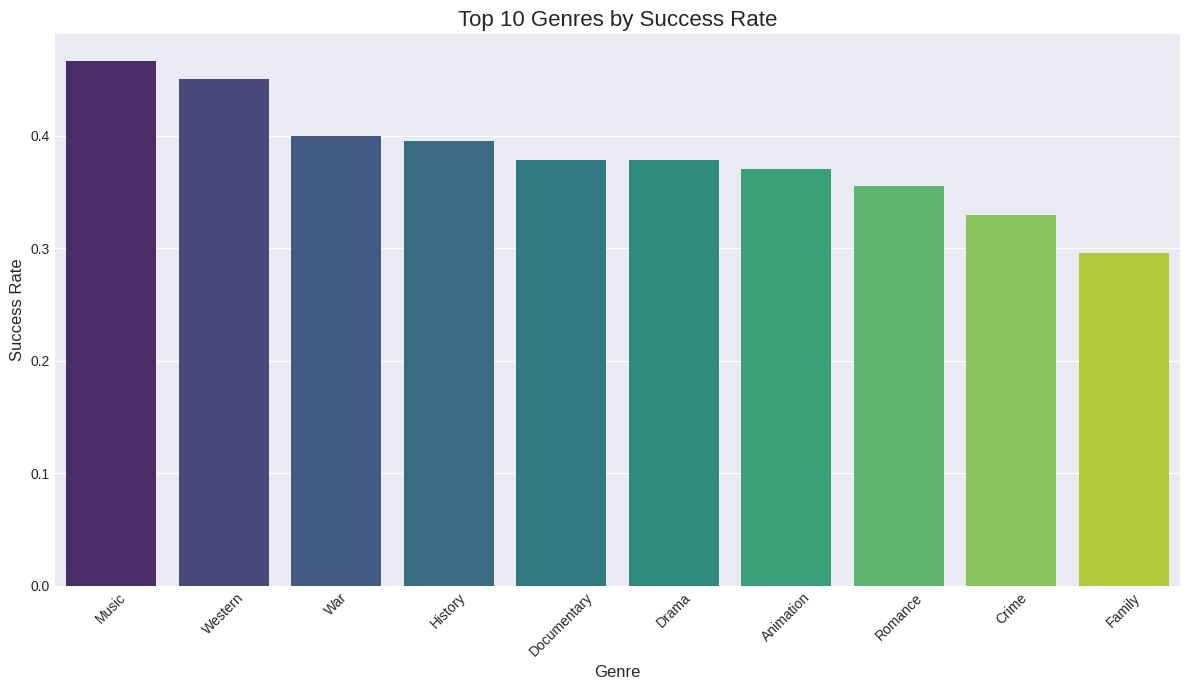

In [9]:
# === 5. EXPLORATORY DATA ANALYSIS (EDA) ===
# Visualize the data to find patterns and insights.

plt.style.use('seaborn-v0_8-darkgrid')

# --- Plot 1: Success Rate by Top Genres ---
print("\nGenerating EDA Plots...")

# Create a new dataframe to analyze genres
genre_df = df.explode('genres')
genre_success_rate = genre_df.groupby('genres')['success'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_success_rate.head(10).index, y=genre_success_rate.head(10).values, palette='viridis')
plt.title('Top 10 Genres by Success Rate', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

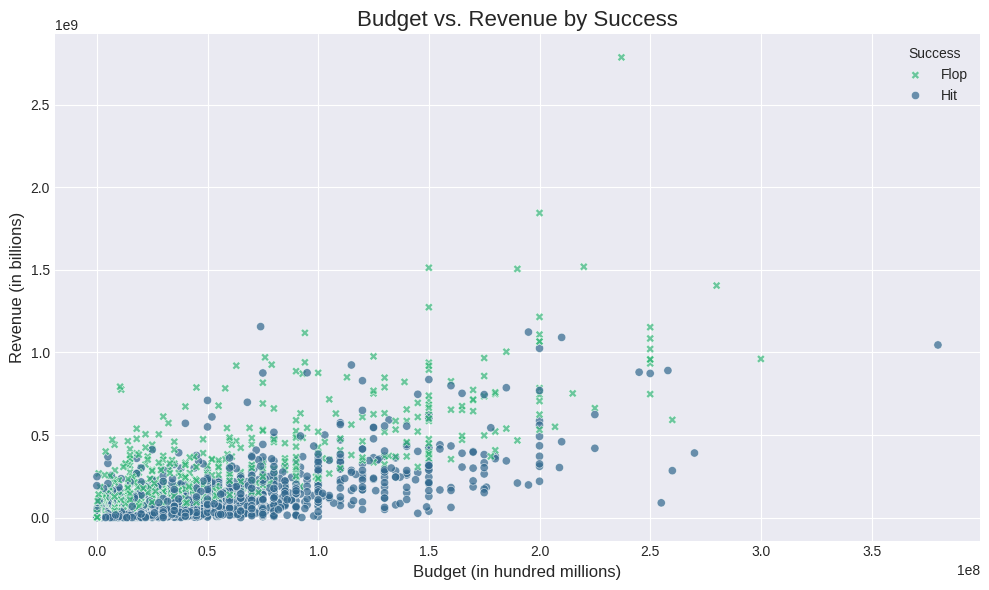

In [11]:
# --- Plot 2: Budget vs. Revenue ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='revenue', hue='success', style='success', palette='viridis', alpha=0.7)
plt.title('Budget vs. Revenue by Success', fontsize=16)
plt.xlabel('Budget (in hundred millions)', fontsize=12)
plt.ylabel('Revenue (in billions)', fontsize=12)
plt.legend(title='Success', labels=['Flop', 'Hit'])
plt.tight_layout()
plt.show()

In [7]:
# === 6. FINAL DATA PREPARATION FOR MODELING ===
# Convert all our text-based features into numerical format using one-hot encoding.

# Combine all text features into a single string for each movie
df['text_features'] = df['genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                      df['keywords'].apply(lambda x: ' '.join(x)) + ' ' + \
                      df['cast'].apply(lambda x: ' '.join(x)) + ' ' + \
                      df['director']

# Use Scikit-learn's TfidfVectorizer to convert text into numerical features
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000) # Use top 1000 most frequent words
text_features = vectorizer.fit_transform(df['text_features']).toarray()

# Combine numerical features with the new text features
numerical_features = df[['budget', 'vote_average', 'vote_count', 'runtime', 'popularity']].values
X = np.hstack((numerical_features, text_features))
y = df['success'].values

print(f"\nData is ready for modeling. Feature matrix shape: {X.shape}")


Data is ready for modeling. Feature matrix shape: (3211, 1005)



Training the Random Forest model...
Model training complete.

Model Accuracy: 0.88

Classification Report:
              precision    recall  f1-score   support

        Flop       0.91      0.92      0.91       447
         Hit       0.81      0.78      0.79       196

    accuracy                           0.88       643
   macro avg       0.86      0.85      0.85       643
weighted avg       0.87      0.88      0.88       643



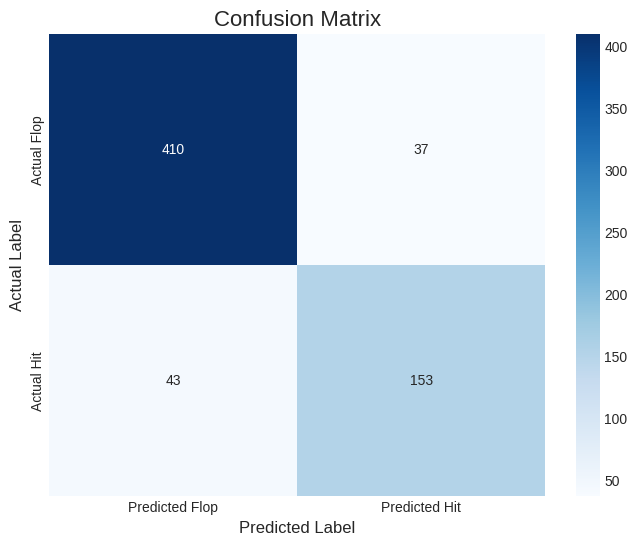


--- Project Execution Finished ---


In [8]:
# === 7. MODEL TRAINING AND EVALUATION ===
# Split the data, train the model, and evaluate its performance.

# Split data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, min_samples_leaf=2)
print("\nTraining the Random Forest model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# --- Evaluate the model ---
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Flop', 'Hit']))

# --- Plot 3: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Flop', 'Predicted Hit'],
            yticklabels=['Actual Flop', 'Actual Hit'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print("\n--- Project Execution Finished ---")